This project is an exercise in leveraging features from text using a dataset previously harvested for the purpose of predicting Academy Awards nominations and wins.<br>
Specifically, it includes:<br>
- clustering of movies to assess what groupings the ML algorithm would find based on movie descriptions (`summary`);
- multi-label classification of movies by genre (where each movie can represent more than one genre), using first movie titles (`primaryTitle`) and then - movie summaries.

## 1. Imports and data setup

In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.corpus import stopwords
#nltk.download('wordnet')
#nltk.download('stopwords')
import gensim
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import k_means, DBSCAN, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph, KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import silhouette_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import warnings

In [2]:
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [67]:
all_movies = pd.read_csv('./post-dsi/NLP_movie-topics/movies_data.csv', low_memory= False, index_col='tconst')
all_summaries = all_movies[all_movies['summary'].notna()]['summary']

In [64]:
all_movies.shape[0]

183485

## 2. Clustering of movies into "like" groupings

After transforming summaries into numerical data, I then use three types of clustering algorithms to group movies and see which performs best:<br>
- centroid-based K-Neighbors algorithm,
- density-based DBSCAN,
- hierarchical agglomerative clustering.

### 2.1. Transforming data through bag-of-n-grams vectorization

Because the entire dataset is large, for computational efficiency, I will perform clustering on a subset including only 10% of all movies:

In [68]:
sample_summaries = all_summaries.sample(frac = 0.1)

First, the summaries are transformed into a bag of n-grams, and each movie is represented as a vector with counts of the n-grams that are part of its summary.

In [69]:
cv = CountVectorizer(stop_words = 'english', ngram_range=(1,3), max_df = 0.99, min_df = 0.001, analyzer = 'word', token_pattern= '[a-zA-Z]+')

data = cv.fit_transform(sample_summaries)
data = data.todense()
data.shape

(14425, 2848)

The five rows below represent such vectors for the corresponding movies:

In [71]:
data_df = pd.DataFrame(data, columns = list(cv.vocabulary_.keys()), index = sample_summaries.index)
data_df.head()

,inspector,sets,pursuit,mysterious,serial,killer,teen,girls,murders,brutally,...,christ,voyage,released prison,devastating,prepares,conversation,object,life changes,sleazy,life story
tconst,,,,,,,,,,,,,,,,,,,,,
tt10133300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt2131676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt1446673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt4738912,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt7043506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Before clustering, the vector values are standardized using the Standard Scaler transformer:

In [78]:
stan = StandardScaler()
sample_data_sc = stan.fit_transform(data)

sample_data = pd.DataFrame(sample_data_sc, columns = data_df.columns, index = data_df.index)
sample_data.head()

,inspector,sets,pursuit,mysterious,serial,killer,teen,girls,murders,brutally,...,christ,voyage,released prison,devastating,prepares,conversation,object,life changes,sleazy,life story
tconst,,,,,,,,,,,,,,,,,,,,,
tt10133300,-0.077896,-0.034011,-0.057781,-0.046408,-0.036317,-0.047885,-0.032264,-0.0441,-0.044199,-0.039083,...,-0.110183,-0.037261,-0.06834,-0.041782,-0.038183,-0.032264,-0.067309,-0.032264,-0.045972,-0.042493
tt2131676,-0.077896,-0.034011,-0.057781,-0.046408,-0.036317,-0.047885,-0.032264,-0.0441,-0.044199,-0.039083,...,-0.110183,-0.037261,-0.06834,-0.041782,-0.038183,-0.032264,-0.067309,-0.032264,-0.045972,-0.042493
tt1446673,-0.077896,-0.034011,-0.057781,-0.046408,-0.036317,-0.047885,-0.032264,-0.0441,-0.044199,-0.039083,...,-0.110183,-0.037261,-0.06834,-0.041782,-0.038183,-0.032264,-0.067309,-0.032264,-0.045972,-0.042493
tt4738912,-0.077896,-0.034011,-0.057781,-0.046408,-0.036317,-0.047885,-0.032264,-0.0441,-0.044199,-0.039083,...,-0.110183,-0.037261,-0.06834,-0.041782,-0.038183,-0.032264,-0.067309,-0.032264,-0.045972,-0.042493
tt7043506,-0.077896,-0.034011,-0.057781,-0.046408,-0.036317,-0.047885,-0.032264,-0.0441,-0.044199,-0.039083,...,-0.110183,-0.037261,-0.06834,-0.041782,-0.038183,-0.032264,-0.067309,-0.032264,-0.045972,-0.042493


### 2.2. Centroid-based clustering (KMeans)

#### 2.2.1. Determining the right k

Because I am looking for unknown patterns and do not have a ready hypothesis as far as the "ideal" number of clusters the algorithm should attempt to find, I first search for the right value of k using the intertia scores calculated for k's between 10 and 200 (with a step of 10, to improve speed of processing) and the elbow method:

In [88]:
random_ks = np.random.choice(range(10,int(sample_data.shape[0]/3)), size = 50, replace = False)

In [91]:
inertia = {} # empty dictionary to store the calculated value of inertia for each tested value of k:
for k in random_ks: # assessing KMeans clustering with randomly selected values for k
    kmeans = KMeans(n_clusters= k) # initiating and fitting a K-means model with k clusters
    kmeans.fit(sample_data)
    inertia[k] = kmeans.inertia_ # assigning the key and value to the dictionary

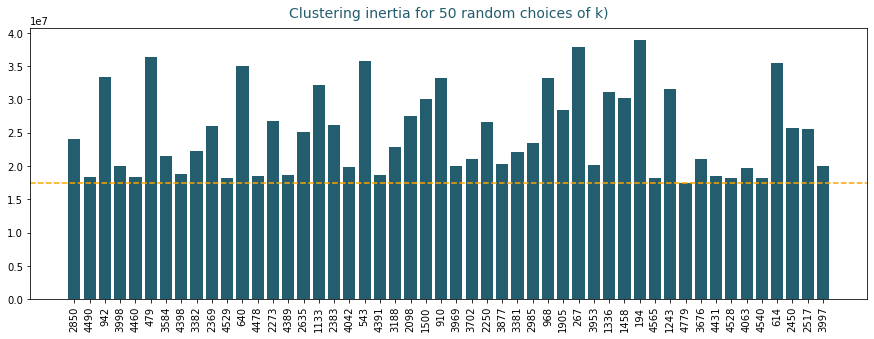

In [190]:
plt.figure(figsize = (15,5))
plt.bar(range(50), list(inertia.values()), color = '#245D6E')
plt.xticks(range(50), list(inertia.keys()), rotation = 90)
plt.title('Clustering inertia for 50 random choices of k)', fontdict = {"color": '#245D6E', 'fontsize': 14, 'fontweight': 5}, pad = 10)
plt.axhline(np.min(list(inertia.values())), ls = '--', color = 'orange')
plt.savefig('./post-dsi/NLP_movie-topics/random_ks.png', pad_inches = 0.2)

![]('./post-dsi/NLP_movie-topics/random_ks.png')

Calculating the silhouette score for the number of clusters with lowest inertia:

In [111]:
km_4800 = KMeans(n_clusters= 4800, n_init= 20, verbose= 0)
km_4800.fit(sample_data)

silhouette_score(sample_data.iloc[:,:-1], km_4800.predict(sample_data))

-0.05671991988472161

Checking for trade-off between lower count of clusters and silhouette score:

In [112]:
km_1000 = KMeans(n_clusters= 1000, n_init= 20, verbose= 0)
km_1000.fit(sample_data)

silhouette_score(sample_data.iloc[:,:-1], km_1000.predict(sample_data))

-0.09319299592741655

In [116]:
km_100 = KMeans(n_clusters= 100, n_init= 20, verbose= 0)
km_100.fit(sample_data)

silhouette_score(sample_data.iloc[:,:-1], km_100.predict(sample_data))

-0.10201928887477069

In [117]:
preds = km_100.predict(sample_data)

In [118]:
counts_by_cluster = {}
for cluster in range(0,100):
    counts_by_cluster[cluster] = sum([1 for pred in preds if pred == cluster])

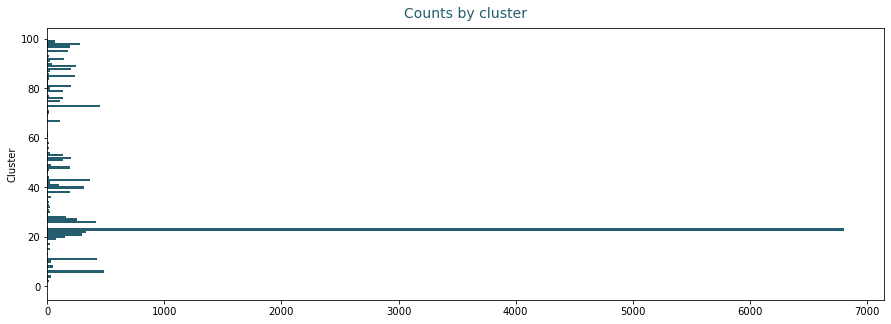

In [127]:
plt.figure(figsize = (15,5))
plt.barh(y = list(counts_by_cluster.keys()), width = list(counts_by_cluster.values()), color = '#245D6E', height = 0.9)
plt.title('Counts by cluster',fontdict = {"color": '#245D6E', 'fontsize': 14, 'fontweight': 5}, pad = 10)
plt.ylabel('Cluster');

In [129]:
counts_by_cluster[23]/sample_data.shape[0]

0.47202772963604855

In [130]:
sample_data['km100_cluster'] = km_100.predict(sample_data)

In [178]:
def show_cluster(num_cluster, n_movies, column):
    size = min(n_movies, sample_data[sample_data[column]==num_cluster].shape[0])
    subset = sample_data[sample_data[column]==num_cluster].sample(size).index
    return all_movies.loc[subset,'summary']

In [179]:
pd.set_option('display.max_colwidth', 0)

show_cluster(23,10, 'km100_cluster')

tconst
tt0105188    Mario leads a normal life, working in a Milan bank. His daily routine is shattered when he witnesses a murder and is shot himself by the killer, a deranged police commissioner. To save his ...                                    
tt1124001    The film is named after the local football stadium located in the town of Be'er Sheva in southern Israel. Vasermil tells the story of three teenagers who live in the same tough neighborhood...                                    
tt0113850    30ish Patrick and teenage Dominic are two brothers living alone in a remote farmhouse in the Southwest of Ireland, while their mother is away traveling. When their aunt comes visiting, with...                                    
tt2241376    Juan is a thirty who is bored with her current life. Time ago that you don't see your friends and only is dedicated to work - in a boring place - and to groom. Overwhelmed a day routine, ...\n                    See full synopsi
tt4642970    A killer lla

Cluster # 23 has almost half of the movies in the streamlined dataset - presumably, these movies are difficult to group with others based on their descriptions. I want to test this by calculating the silhouette score for all remaining movies/clusters:

In [138]:
sample_data_subset = sample_data[sample_data['km100_cluster']!=23]

In [137]:
silhouette_score(sample_data[sample_data['km100_cluster']!=23][[col for col in sample_data.columns if col[-7:]!='cluster']], sample_data[sample_data['km100_cluster']!=23]['km100_cluster'])

-0.11469765647910449

The silhouette score after removing the large heterogeneous cluster did not improve - maybe re-clustering the movies which did not fall inside #23 will help:

In [139]:
km_subset = KMeans(n_clusters=100)
km_subset.fit(sample_data_subset)
silhouette_score(sample_data_subset, km_subset.predict(sample_data_subset))

0.012983046227905524

It seems like it might take a different algorithm, or a more curated dataset to achieve better results. Before I try different algorithms, take a look at some randomly picked clusters:

In [181]:
show_cluster(np.random.randint(0,100), 10, 'km100_cluster')

tconst
tt10863328    De'aundre Bonds, actor most known for playing "Stacy" in "The Wood" tells it all in this thrilling documentary about his life. From childhood to the silver screen to prison and back again.
tt0446676     As an ex-gambler teaches a hot-shot college kid some things about playing cards, he finds himself pulled into the world series of poker, where his protégé is his toughest competition.     
Name: summary, dtype: object

Based on a review of several random samples, the algorithm put together movies which share some words or expressions less common among other movies (e.g. "reunion", "hip-hop", "based on a true story").

#### 2.3. Density-based clustering (DBSCAN)

Since the centroid-based K-Means algorithm had some trouble grouping movies into meaningful clusters, maybe the density-based DBSCAN can do better?

In [171]:
db = DBSCAN()
db.fit(sample_data.iloc[:,:-2])

sample_data['db_cluster'] = db.labels_
sample_data['db_cluster'].value_counts()

-1    14418
 0    7    
Name: db_cluster, dtype: int64

In [172]:
silhouette_score(sample_data.iloc[:,:-3], sample_data['db_cluster'])

-0.31495023172193176

Evidently, the examined features offer no groupings of movies that demonstrate relative density worth clustering together - almost all movies are determined to be outliers.

#### 2.4. Agglomerative Clustering

In [174]:
agg = AgglomerativeClustering(n_clusters = 100)

agg.fit(sample_data.iloc[:,:-3])

sample_data['agg_cluster'] = agg.labels_
#sample_data['agg_cluster'].value_counts()

In [175]:
silhouette_score(sample_data.iloc[:,:-3], sample_data['agg_cluster'])

-0.5853711291311021

In [177]:
sample_data['agg_cluster'].value_counts()

1     11982
0     244  
4     142  
10    119  
11    79   
      ..   
77    12   
66    12   
38    12   
82    12   
16    11   
Name: agg_cluster, Length: 100, dtype: int64

Similar to K-Means, agglomerative clustering returned one massive cluster and a number of smaller ones. The overall silhouette score is not at all encouraging but unlike the K-Means results, there are no groupings of 1 or 2 movies, so let's take a look at some samples:

In [187]:
show_cluster(np.random.randint(2,100), 10, 'agg_cluster')

tconst
tt1967634    THE POWER OF WORDS takes its form from R. Lee Cantelon's book, THE WORDS: Jesus of Nazareth, where the core words of Christ are edited together without the rest of the intervening text. It ...                                            
tt1168774    From director Jean Claude LaMarre (Color of the Cross), comes another epic film about the ministry of Jesus Christ. This daring film portrays the resurrection of Jesus Christ and his ...                                                  
tt0140073    A look at Jesus Christ's life, from his childhood to the meeting with the Apostles, focusing on his compassionate human side.                                                                                                               
tt7697348    40: The Temptation of Christ is detailed in the Gospels of Matthew, Mark and Luke. According to these texts, after being baptized by John the Baptist, Jesus fasted for forty days and forty ...                                      

It seems like the smaller clusters are fairly coherent, and perhaps built on a more meaningful relationship than the occurrence of a single word, which was often the case for the K-Means-derived groupings.

### 2.4. Visualizing results using PCA

In [241]:
pca = PCA(n_components=2)
pcmps = pca.fit_transform(sample_data.iloc[:,:-3])
sample_data['pc1'] = pcmps[:,0]
sample_data['pc2'] = pcmps[:,1]

In [242]:
sample_data.head()

,inspector,sets,pursuit,mysterious,serial,killer,teen,girls,murders,brutally,...,object,life changes,sleazy,life story,km_cluster,km100_cluster,db_cluster,agg_cluster,pc1,pc2
tconst,,,,,,,,,,,,,,,,,,,,,
tt10133300,-0.077896,-0.034011,-0.057781,-0.046408,-0.036317,-0.047885,-0.032264,-0.0441,-0.044199,-0.039083,...,-0.067309,-0.032264,-0.045972,-0.042493,329,23,-1,1,-61.453653,-1.238204
tt2131676,-0.077896,-0.034011,-0.057781,-0.046408,-0.036317,-0.047885,-0.032264,-0.0441,-0.044199,-0.039083,...,-0.067309,-0.032264,-0.045972,-0.042493,462,38,-1,1,71.553871,2.943211
tt1446673,-0.077896,-0.034011,-0.057781,-0.046408,-0.036317,-0.047885,-0.032264,-0.0441,-0.044199,-0.039083,...,-0.067309,-0.032264,-0.045972,-0.042493,712,73,-1,1,321.554033,0.511350
tt4738912,-0.077896,-0.034011,-0.057781,-0.046408,-0.036317,-0.047885,-0.032264,-0.0441,-0.044199,-0.039083,...,-0.067309,-0.032264,-0.045972,-0.042493,329,23,-1,1,-61.448770,-0.543702
tt7043506,-0.077896,-0.034011,-0.057781,-0.046408,-0.036317,-0.047885,-0.032264,-0.0441,-0.044199,-0.039083,...,-0.067309,-0.032264,-0.045972,-0.042493,329,23,-1,1,-61.452299,-0.100794


In [339]:
def plot_five_clusters(column, cluster1, cluster2, cluster3, cluster4, cluster5):
    subset = sample_data[sample_data[column].isin([cluster1, cluster2, cluster3, cluster4, cluster5])]
    subset['color'] = subset[column].map({cluster1: '#264653', cluster2: '#2a9d8f', cluster3: '#e9c46a', cluster4: '#f4a261', cluster5: '#e76f51'})
    #plt.figure(figsize = (10,10))
    method = {}
    method['km100_cluster'] = 'KMeans'
    method['agg_cluster'] = 'Agglomerative'
    plt.title(f"Clusters #{cluster1}, {cluster2}, {cluster3}, {cluster4}, and {cluster5} from {method[column]} clustering", fontdict = {"color": 'black', 'fontsize': 14, 'fontweight': 5}, pad = 10)
    plt.scatter(subset['pc1'], subset['pc2'], c=subset['color'], alpha = 0.8)
    #plt.savefig('./post-dsi/NLP_movie-topics/vis_clusters.png', pad_inches = 0.2)
    #plt.show()

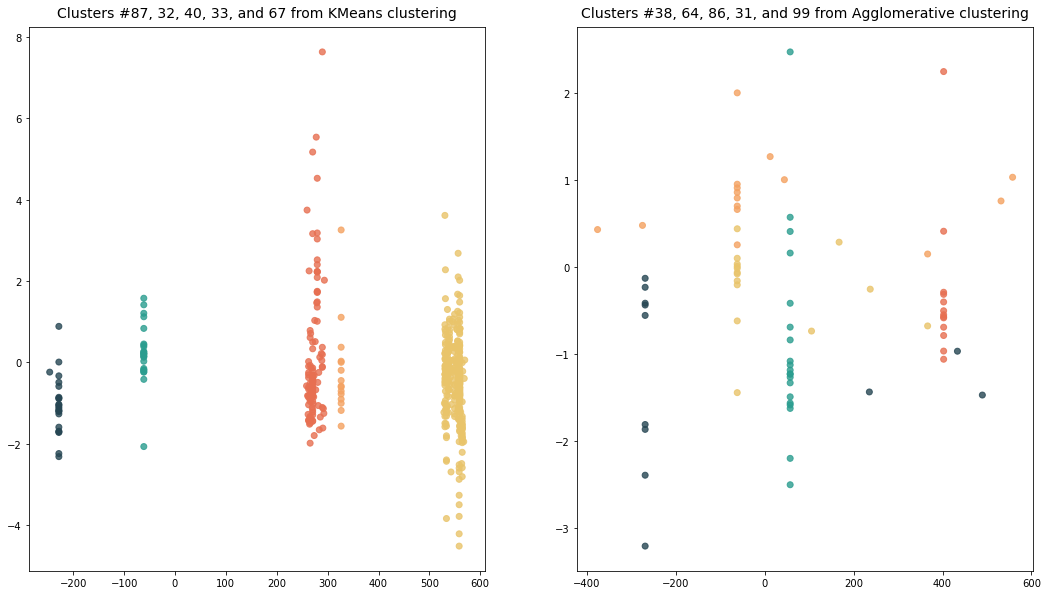

In [341]:
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plot_five_clusters('km100_cluster', 87, 32, 40, 33, 67)
plt.subplot(1,2,2)
plot_five_clusters('agg_cluster', 38, 64, 86, 31, 99);
plt.savefig('./post-dsi/NLP_movie-topics/KM_vs_Agg.png')

## 3. Predicting genre using text features from movie titles / summaries

### 3.1. Creating labels for multi-output classification

In order to perform **multi-output classification** (multiple genres represented, plus each movie can represent multiple genres), I will first create binary labels and streamlight the large dataset to only represent most popular genres.

In [5]:
unique_genres = []
for entry in all_movies['genres']:
    if entry.find(",") > 0:
        split_entry = entry.split(",")
        for genre in split_entry:
            unique_genres.append(genre)

unique_genres = list(set(unique_genres))        

In [6]:
print(f"The dataset contains labels for {len(unique_genres)} unique genres: {unique_genres}.")

The dataset contains labels for 25 unique genres: ['Western', 'Romance', 'Documentary', 'Adult', 'News', 'Talk-Show', 'War', 'History', 'Crime', 'Mystery', 'Drama', 'Sci-Fi', 'Musical', 'Reality-TV', 'Comedy', 'Sport', 'Horror', 'Family', 'Thriller', 'Adventure', 'Fantasy', 'Biography', 'Action', 'Music', 'Animation'].


In [7]:
genre_counts = []
for genre in unique_genres:
    count_genre = 0
    for movie_genres in all_movies['genres']:
        if genre in movie_genres:
            count_genre +=1 
#    print(f"{genre} occurs {count_genre} times.")
    genre_counts.append(count_genre)
    
genre_counts_df = pd.DataFrame({'genre': unique_genres, 'count': genre_counts})
genre_counts_df.sort_values(['count'], ascending = False, inplace = True)

In [8]:
genre_counts_df['cum_perc'] = np.cumsum(list(genre_counts_df['count']))/genre_counts_df['count'].sum()

In [9]:
genre_counts_df['rank'] = genre_counts_df['cum_perc'].rank()
genre_counts_df

,genre,count,cum_perc,rank
10,Drama,75226,0.249406,1.0
2,Documentary,45197,0.399253,2.0
14,Comedy,39363,0.529758,3.0
22,Action,16761,0.585327,4.0
18,Thriller,16677,0.640619,5.0
1,Romance,16547,0.695479,6.0
16,Horror,13618,0.740628,7.0
8,Crime,12207,0.781099,8.0
19,Adventure,8415,0.808999,9.0
21,Biography,7838,0.834985,10.0


- The top ten genres by count represent 83% of the observations - when classifying, I will use this subset of data
- To filter the dataset, I will remove all movies whose `genres` value include genres below the cutoff ("Family" and below)

In [10]:
top10_genres = list(genre_counts_df[genre_counts_df['rank']<=10]['genre'])

In [11]:
for genre in top10_genres:
    all_movies[genre] = all_movies['genres'].apply(lambda x: 1 if x.find(genre) >= 0 else 0)

In [12]:
all_movies.sample(5)

,primaryTitle,summary,genres,runtime,Drama,Documentary,Comedy,Action,Thriller,Romance,Horror,Crime,Adventure,Biography
tconst,,,,,,,,,,,,,,
tt5270464,The 2015 World Series,This official film from Major League Baseball ...,Documentary,NaN,0,1,0,0,0,0,0,0,0,0
tt13039174,The Taste of Ricecake - Director's Edition,NaN,Romance,70 min,0,0,0,0,0,1,0,0,0,0
tt2124804,I Married a Czech Boy,'I Married a Czech Boy' is an off-beat and tru...,"Comedy,Romance",104 min,0,0,1,0,0,1,0,0,0,0
tt7450858,In the Name of All Canadians,An anthology of short films illustrating the s...,Documentary,88 min,0,1,0,0,0,0,0,0,0,0
tt0406038,Loggerheads,Three overlapping stories of estranged familie...,Drama,NaN,1,0,0,0,0,0,0,0,0,0


In [13]:
all_movies['keep'] =  all_movies[top10_genres].apply(lambda x: sum(x), axis = 1)
genre_sel_movies = all_movies[all_movies['keep']>0].drop('keep', axis = 1)

In [14]:
genre_sel_movies.dropna(subset = ['primaryTitle','summary'], inplace = True)

In [15]:
genre_sel_movies.sample(3)

,primaryTitle,summary,genres,runtime,Drama,Documentary,Comedy,Action,Thriller,Romance,Horror,Crime,Adventure,Biography
tconst,,,,,,,,,,,,,,
tt1754241,My Blood,A day in a man's life turns into a struggle ag...,Drama,85 min,1,0,0,0,0,0,0,0,0,0
tt0107508,Manhattan by Numbers,MANHATTAN BY NUMBERS is the story of George Mu...,Drama,110 min,1,0,0,0,0,0,0,0,0,0
tt2305029,Salvation for the Lost,"""VI"" is a mafia movie set in Baltimore, Maryla...",Crime,88 min,0,0,0,0,0,0,0,1,0,0


### 3.2. Classifying movies by genre using `primaryTitle`

#### 3.2.1. Setting up feaures from text

In [16]:
train_all, test_all = train_test_split(genre_sel_movies, test_size = 0.1, stratify = genre_sel_movies['Drama'])

In [17]:
print(f"The training set includes {train_all.shape[0]} titles and the test set has {test_all.shape[0]} movies")

The training set includes 124105 titles and the test set has 13790 movies


In [20]:
cvec = CountVectorizer(stop_words = 'english', ngram_range=(1,3), max_df = 0.99, min_df = 0.001, analyzer = 'word', token_pattern= '[a-zA-Z]+')
title_train_features = cvec.fit_transform(train_all['primaryTitle'])
stan = StandardScaler()
title_train_features_sc = stan.fit_transform(title_train_features.todense())
title_train_features_df = pd.DataFrame(data = title_train_features_sc, columns = cvec.get_feature_names(), index = train_all.index)
title_train_features_df.head()

,al,america,american,angel,angels,art,away,b,baby,bad,...,woman,women,world,x,y,year,years,young,z,zero
tconst,,,,,,,,,,,,,,,,,,,,,
tt6331850,-0.03813,-0.045755,-0.062898,-0.038732,-0.034165,-0.045681,-0.031698,-0.043703,-0.033915,-0.045185,...,-0.044846,-0.043081,-0.070169,-0.035967,-0.051908,-0.040877,-0.040507,-0.038923,-0.032501,-0.032504
tt1475365,-0.03813,-0.045755,-0.062898,-0.038732,-0.034165,-0.045681,-0.031698,-0.043703,-0.033915,-0.045185,...,-0.044846,-0.043081,-0.070169,-0.035967,-0.051908,-0.040877,-0.040507,-0.038923,-0.032501,-0.032504
tt1551615,-0.03813,-0.045755,-0.062898,-0.038732,-0.034165,-0.045681,-0.031698,-0.043703,-0.033915,-0.045185,...,-0.044846,-0.043081,-0.070169,-0.035967,-0.051908,-0.040877,-0.040507,-0.038923,-0.032501,-0.032504
tt3861432,-0.03813,-0.045755,-0.062898,-0.038732,-0.034165,-0.045681,-0.031698,-0.043703,-0.033915,-0.045185,...,-0.044846,-0.043081,-0.070169,-0.035967,-0.051908,-0.040877,-0.040507,-0.038923,-0.032501,-0.032504
tt3407894,-0.03813,-0.045755,-0.062898,-0.038732,-0.034165,-0.045681,-0.031698,-0.043703,-0.033915,-0.045185,...,-0.044846,-0.043081,-0.070169,-0.035967,-0.051908,-0.040877,-0.040507,-0.038923,-0.032501,-0.032504


In [21]:
title_test_features = cvec.transform(test_all['primaryTitle'])
title_test_features_sc = stan.transform(title_test_features.todense())
title_test_features_df = pd.DataFrame(data = title_test_features_sc, columns = cvec.get_feature_names(), index = test_all.index)
title_test_features_df.head()

,al,america,american,angel,angels,art,away,b,baby,bad,...,woman,women,world,x,y,year,years,young,z,zero
tconst,,,,,,,,,,,,,,,,,,,,,
tt3061534,-0.03813,-0.045755,-0.062898,-0.038732,-0.034165,-0.045681,-0.031698,-0.043703,-0.033915,-0.045185,...,-0.044846,-0.043081,-0.070169,-0.035967,-0.051908,-0.040877,-0.040507,-0.038923,-0.032501,-0.032504
tt0834153,-0.03813,-0.045755,-0.062898,-0.038732,-0.034165,-0.045681,-0.031698,-0.043703,-0.033915,-0.045185,...,-0.044846,-0.043081,-0.070169,-0.035967,-0.051908,-0.040877,-0.040507,-0.038923,-0.032501,-0.032504
tt0426582,-0.03813,-0.045755,-0.062898,-0.038732,-0.034165,-0.045681,-0.031698,-0.043703,-0.033915,-0.045185,...,-0.044846,-0.043081,-0.070169,-0.035967,-0.051908,-0.040877,-0.040507,-0.038923,-0.032501,-0.032504
tt4333696,-0.03813,-0.045755,-0.062898,-0.038732,-0.034165,-0.045681,-0.031698,-0.043703,-0.033915,-0.045185,...,-0.044846,-0.043081,-0.070169,-0.035967,-0.051908,-0.040877,-0.040507,-0.038923,-0.032501,-0.032504
tt2066116,-0.03813,-0.045755,-0.062898,-0.038732,-0.034165,-0.045681,-0.031698,-0.043703,-0.033915,-0.045185,...,-0.044846,-0.043081,-0.070169,-0.035967,-0.051908,-0.040877,-0.040507,-0.038923,-0.032501,-0.032504


In [22]:
print(f"Both the training set and the test set represent {title_train_features_df.shape[1]} features.")

Both the training set and the test set represent 229 features.


In [23]:
train_labels = train_all[top10_genres]
test_labels = test_all[top10_genres]

#### 3.2.2. Setting up, training, and evaluating the classifier:

In [24]:
from sklearn.multioutput import MultiOutputClassifier
moc = MultiOutputClassifier(KNeighborsClassifier(n_neighbors = 10))
moc.fit(title_train_features_df, train_labels)

MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=10))

In [25]:
moc.score(title_test_features_df, test_labels)

0.1873026179864821

In [29]:
preds = moc.predict(title_test_features_df)

In [35]:
preds_df = pd.DataFrame(data = preds, columns = ["pred_"+genre for genre in top10_genres], index = test_all.index)
preds_df.head()

,pred_Drama,pred_Documentary,pred_Comedy,pred_Action,pred_Thriller,pred_Romance,pred_Horror,pred_Crime,pred_Adventure,pred_Biography
tconst,,,,,,,,,,
tt3061534,1,0,0,0,0,0,0,0,0,0
tt0834153,1,0,0,0,0,0,0,0,0,0
tt0426582,0,0,0,0,0,0,0,0,0,0
tt4333696,0,0,0,0,0,0,0,0,0,0
tt2066116,1,0,0,0,0,0,0,0,0,0


In [36]:
test_all = test_all.merge(preds_df, left_index = True, right_index = True)
test_all.sample(5)

,primaryTitle,summary,genres,runtime,Drama,Documentary,Comedy,Action,Thriller,Romance,...,pred_Drama,pred_Documentary,pred_Comedy,pred_Action,pred_Thriller,pred_Romance,pred_Horror,pred_Crime,pred_Adventure,pred_Biography
tconst,,,,,,,,,,,,,,,,,,,,,
tt2400975,The Last Chance: Diary of Comedians,The story revolves around two struggling comic...,Comedy,NaN,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
tt0316824,In Enemy Hands,When American submarine Swordfish is torpedoed...,"Action,Drama,Thriller",94 min,1,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
tt5617554,Class Divide,Documentary about class division and gentrific...,Documentary,74 min,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
tt0192949,Stardom,A young girl is plucked from small-town obscur...,"Comedy,Drama",100 min,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
tt1791618,Susah Jaga Keperawanan di Jakarta,NaN,Comedy,90 min,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The two summaries below checks whether the classifier assigned more than genre label to any of the movies in the test dataset.<br>
First, I compute the number of movies in the test dataset which were labeled with 1, 2, or 3 distinct genres. The second summay lists the number of movies which were assigned 0-4 predicted labels.<br>
For ~3,700 movies, the classifier did not predict a label at all, however, it recognized that over ~1,500 movies belonged to more than one genre.

In [62]:
test_all['real_labels'] = test_all.apply(lambda x: x[top10_genres].sum(), axis = 1)
test_all['real_labels'].value_counts()

1    7915
2    4258
3    1617
Name: real_labels, dtype: int64

In [61]:
test_all['pred_labels'] = test_all.apply(lambda x: x[[col for col in test_all.columns if col[:4] =='pred']].sum(), axis = 1)
test_all['pred_labels'].value_counts()

1    8554
0    3697
2    1430
3     108
4       1
Name: preds_labels, dtype: int64

In [51]:
totals_comp = pd.DataFrame({'real': test_all[top10_genres].agg(np.sum),'predicted': test_all[predss_df.columns].agg(np.sum)}).reset_index()
totals_comp['genre'] = totals_comp['index'].apply(lambda x: x if x[:4]!= 'pred' else x[5:])
totals_comp = totals_comp.pivot_table(index = 'genre')

for genre in top10_genres:
    totals_comp.loc[genre,"tp_t"]=test_all[(test_all[genre]==1) & test_all["pred_"+genre]==1].shape[0]
    totals_comp.loc[genre,"tn_t"]=test_all[(test_all[genre]==0) & test_all["pred_"+genre]==0].shape[0]
    totals_comp.loc[genre,"fp_t"]=test_all[(test_all[genre]==0) & test_all["pred_"+genre]==1].shape[0]
    totals_comp.loc[genre,"fn_t"]=test_all[(test_all[genre]==1) & test_all["pred_"+genre]==0].shape[0]
    
totals_comp['accuracy_t'] = (totals_comp['tp_t'] + totals_comp['tn_t'])/(totals_comp['tp_t'] + totals_comp['tn_t'] + totals_comp['fp_t'] + totals_comp['fn_t'])
totals_comp['recall_t'] = totals_comp['tp_t']/(totals_comp['tp_t'] + totals_comp['fp_t'])
totals_comp['precision_t'] = totals_comp['tp_t']/(totals_comp['tp_t'] + totals_comp['fn_t'])

In [52]:
totals_comp['train_real'] = train_all[totals_comp.index].sum()
totals_comp.sort_values('real', ascending = False)

,predicteds,real,tp,tn,fp,fn,accuracy,recall,precision,train_real
genre,,,,,,,,,,
Drama,6029.0,6344.0,3213.0,10974.0,2816.0,10577.0,0.514394,0.532924,0.232995,57090
Documentary,2472.0,3451.0,1343.0,12661.0,1129.0,12447.0,0.507759,0.543285,0.097389,31103
Comedy,2064.0,3324.0,758.0,12484.0,1306.0,13032.0,0.480131,0.367248,0.054967,30556
Thriller,133.0,1528.0,51.0,13708.0,82.0,13739.0,0.498876,0.383459,0.003698,13606
Romance,383.0,1524.0,125.0,13532.0,258.0,13665.0,0.495178,0.326371,0.009065,12884
Action,195.0,1367.0,93.0,13688.0,102.0,13697.0,0.499674,0.476923,0.006744,12755
Horror,189.0,1209.0,98.0,13699.0,91.0,13692.0,0.500254,0.518519,0.007107,11016
Crime,123.0,1091.0,48.0,13715.0,75.0,13742.0,0.499021,0.390244,0.003481,9763
Adventure,54.0,747.0,13.0,13749.0,41.0,13777.0,0.498985,0.240741,0.000943,6949


In [69]:
def see_sample(genre, tp_fn_fp_tn, n):
    if tp_fn_fp_tn == 'tp':
        sample = test_all[(test_all[genre] == 1) & (test_all['pred_'+genre] == 1)].sample(n).iloc[:,:4]
    if tp_fn_fp_tn == 'tn':
        sample = test_all[(test_all[genre] == 0) & (test_all['pred_'+genre] == 0)].sample(n).iloc[:,:4]
    if tp_fn_fp_tn == 'fp':
        sample = test_all[(test_all[genre] == 0) & (test_all['pred_'+genre] == 1)].sample(n).iloc[:,:4]
    if tp_fn_fp_tn == 'fn':
        sample = test_all[(test_all[genre] == 1) & (test_all['pred_'+genre] == 0)].sample(n).iloc[:,:4]
    return sample

In [73]:
see_sample('Romance', 'fn', 3)

,primaryTitle,summary,genres,runtime
tconst,,,,
tt7371684,Loving in Tandem,hine (Maymay Entrata) is a jolly and happy-go-...,"Comedy,Romance",108 min
tt1110275,Ready or Not (Any Other Way),NaN,"Comedy,Romance",NaN
tt2375567,Super Model,A wine baron (Harsh Chhaya) wants to use a sup...,"Drama,Mystery,Romance",83 min


Clearly (and understandably), predicting genres from only the title of a movie was problematic for the algorithm. Next, I'm going to see if the performance improves when instead of just the title, the estimator uses features from the movies' descriptive summaries.

### 3.3. Classifying movies by genre using `summary`

#### 3.3.1. Setting up feaures from text

In [18]:
print(f"The training set includes {train_all.shape[0]} titles and the test set has {test_all.shape[0]} movies")

The training set includes 124105 titles and the test set has 13790 movies


In [19]:
cvecs = CountVectorizer(stop_words = 'english', ngram_range=(1,3), max_df = 0.99, min_df = 0.001, analyzer = 'word', token_pattern= '[a-zA-Z]+')
summ_train_features = cvecs.fit_transform(train_all['summary'])
stans = StandardScaler()
summ_train_features_sc = stans.fit_transform(summ_train_features.todense())
summ_train_features_df = pd.DataFrame(data = summ_train_features_sc, columns = cvecs.get_feature_names(), index = train_all.index)
summ_train_features_df.head()

,abandoned,abducted,ability,able,abroad,absence,abuse,abused,abusive,academy,...,young women,younger,younger brother,youngest,youngsters,youth,zealand,zombie,zombies,zone
tconst,,,,,,,,,,,,,,,,,,,,,
tt2400447,-0.081507,-0.035706,-0.041479,-0.054536,-0.042524,-0.032645,-0.048379,-0.034566,-0.04654,-0.037869,...,-0.043558,-0.068116,-0.03957,-0.03444,-0.035248,-0.073737,-0.033919,-0.046428,-0.03902,-0.032684
tt1985176,-0.081507,-0.035706,-0.041479,-0.054536,-0.042524,-0.032645,-0.048379,-0.034566,-0.04654,-0.037869,...,-0.043558,-0.068116,-0.03957,-0.03444,-0.035248,-0.073737,-0.033919,-0.046428,-0.03902,-0.032684
tt4339864,-0.081507,-0.035706,-0.041479,-0.054536,-0.042524,-0.032645,-0.048379,-0.034566,-0.04654,-0.037869,...,-0.043558,-0.068116,-0.03957,-0.03444,-0.035248,-0.073737,-0.033919,-0.046428,-0.03902,-0.032684
tt4417518,-0.081507,-0.035706,-0.041479,-0.054536,-0.042524,-0.032645,-0.048379,-0.034566,-0.04654,-0.037869,...,-0.043558,-0.068116,-0.03957,-0.03444,-0.035248,-0.073737,-0.033919,-0.046428,-0.03902,-0.032684
tt3296156,-0.081507,-0.035706,-0.041479,-0.054536,-0.042524,-0.032645,-0.048379,-0.034566,-0.04654,-0.037869,...,-0.043558,-0.068116,-0.03957,-0.03444,-0.035248,-0.073737,-0.033919,-0.046428,-0.03902,-0.032684


In [20]:
summ_test_features = cvecs.transform(test_all['summary'])
summ_test_features_sc = stans.transform(summ_test_features.todense())
summ_test_features_df = pd.DataFrame(data = summ_test_features_sc, columns = cvecs.get_feature_names(), index = test_all.index)
summ_test_features_df.head()

,abandoned,abducted,ability,able,abroad,absence,abuse,abused,abusive,academy,...,young women,younger,younger brother,youngest,youngsters,youth,zealand,zombie,zombies,zone
tconst,,,,,,,,,,,,,,,,,,,,,
tt0109757,-0.081507,-0.035706,-0.041479,-0.054536,-0.042524,-0.032645,-0.048379,-0.034566,-0.04654,-0.037869,...,-0.043558,-0.068116,-0.03957,-0.03444,-0.035248,-0.073737,-0.033919,-0.046428,-0.03902,-0.032684
tt7521804,-0.081507,-0.035706,-0.041479,-0.054536,-0.042524,-0.032645,-0.048379,-0.034566,-0.04654,-0.037869,...,-0.043558,-0.068116,-0.03957,-0.03444,-0.035248,-0.073737,-0.033919,-0.046428,-0.03902,-0.032684
tt0253842,-0.081507,-0.035706,-0.041479,-0.054536,-0.042524,-0.032645,-0.048379,-0.034566,-0.04654,-0.037869,...,-0.043558,-0.068116,-0.03957,-0.03444,-0.035248,-0.073737,-0.033919,-0.046428,-0.03902,-0.032684
tt7282952,-0.081507,-0.035706,-0.041479,-0.054536,-0.042524,-0.032645,-0.048379,-0.034566,-0.04654,-0.037869,...,-0.043558,-0.068116,-0.03957,-0.03444,-0.035248,-0.073737,-0.033919,-0.046428,-0.03902,-0.032684
tt2196023,-0.081507,-0.035706,-0.041479,-0.054536,-0.042524,-0.032645,-0.048379,-0.034566,-0.04654,-0.037869,...,-0.043558,-0.068116,-0.03957,-0.03444,-0.035248,-0.073737,-0.033919,-0.046428,-0.03902,-0.032684


In [21]:
print(f"Both the training set and the test set represent {summ_train_features_df.shape[1]} features.")

Both the training set and the test set represent 2775 features.


In [22]:
train_labels = train_all[top10_genres]
test_labels = test_all[top10_genres]

#### 3.3.2. Setting up, training, and evaluating the classifier:

In [23]:
from sklearn.multioutput import MultiOutputClassifier
mocs = MultiOutputClassifier(KNeighborsClassifier(n_neighbors = 5))
mocs.fit(summ_train_features_df, train_labels)

MultiOutputClassifier(estimator=KNeighborsClassifier())

In [25]:
mocs.score(summ_test_features_df, test_labels)

0.17635968092820883

Surprisingly, the average accuracy of the classifier trained on movie descriptions/summaries is not better than that trained only on titles.

In [26]:
predss = mocs.predict(summ_test_features_df)

In [28]:
predss_df = pd.DataFrame(data = predss, columns = ["preds_"+genre for genre in top10_genres], index = test_all.index)

predss_df.head()

,preds_Drama,preds_Documentary,preds_Comedy,preds_Action,preds_Thriller,preds_Romance,preds_Horror,preds_Crime,preds_Adventure,preds_Biography
tconst,,,,,,,,,,
tt0109757,0,0,0,0,0,0,0,0,0,0
tt7521804,0,0,0,0,0,0,0,0,0,0
tt0253842,0,0,0,0,0,0,0,0,0,0
tt7282952,0,0,0,0,0,0,0,0,0,0
tt2196023,1,0,0,0,0,0,0,0,0,0


In [30]:
test_all = test_all.merge(predss_df, left_index = True, right_index = True)
test_all.sample(5)

,primaryTitle,summary,genres,runtime,Drama,Documentary,Comedy,Action,Thriller,Romance,...,preds_Drama,preds_Documentary,preds_Comedy,preds_Action,preds_Thriller,preds_Romance,preds_Horror,preds_Crime,preds_Adventure,preds_Biography
tconst,,,,,,,,,,,,,,,,,,,,,
tt5768380,The Seer,When Carol Petty's eight-year old son is kidna...,Drama,112 min,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
tt1330606,En plein coeur,"Benoît and Jimi, one big boy and a little man,...",Drama,NaN,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
tt1326740,Blind Fate,A young man's search for peace and meaning aft...,Drama,105 min,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt5247392,The Montagnards,Hear the compelling story of how the tribes pe...,Documentary,120 min,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0846050,The Night Swim,"Arthur has lost just his wife, family has gath...",Drama,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The two summaries below checks whether the classifier assigned more than genre label to any of the movies in the test dataset.<br>
First, I compute the number of movies in the test dataset which were labeled with 1, 2, or 3 distinct genres. The second summay lists the number of movies which were assigned 0-4 predicted labels.<br>
For ~3,700 movies, the classifier did not predict a label at all, however, it recognized that over ~1,500 movies belonged to more than one genre.

In [62]:
test_all['real_labels'] = test_all.apply(lambda x: x[top10_genres].sum(), axis = 1)
test_all['real_labels'].value_counts()

1    7915
2    4258
3    1617
Name: real_labels, dtype: int64

In [61]:
test_all['preds_labels'] = test_all.apply(lambda x: x[[col for col in test_all.columns if col[:4] =='pred']].sum(), axis = 1)
test_all['preds_labels'].value_counts()

1    8554
0    3697
2    1430
3     108
4       1
Name: preds_labels, dtype: int64

In [51]:
totals_comp = pd.DataFrame({'real': test_all[top10_genres].agg(np.sum),'predicteds': test_all[predss_df.columns].agg(np.sum)}).reset_index()
totals_comp['genre'] = totals_comp['index'].apply(lambda x: x if x[:5]!= 'preds' else x[6:])
totals_comp = totals_comp.pivot_table(index = 'genre')

for genre in top10_genres:
    totals_comp.loc[genre,"tp"]=test_all[(test_all[genre]==1) & test_all["preds_"+genre]==1].shape[0]
    totals_comp.loc[genre,"tn"]=test_all[(test_all[genre]==0) & test_all["preds_"+genre]==0].shape[0]
    totals_comp.loc[genre,"fp"]=test_all[(test_all[genre]==0) & test_all["preds_"+genre]==1].shape[0]
    totals_comp.loc[genre,"fn"]=test_all[(test_all[genre]==1) & test_all["preds_"+genre]==0].shape[0]
    
totals_comp['accuracy'] = (totals_comp['tp'] + totals_comp['tn'])/(totals_comp['tp'] + totals_comp['tn'] + totals_comp['fp'] + totals_comp['fn'])
totals_comp['recall'] = totals_comp['tp']/(totals_comp['tp'] + totals_comp['fp'])
totals_comp['precision'] = totals_comp['tp']/(totals_comp['tp'] + totals_comp['fn'])

In [52]:
totals_comp['train_real'] = train_all[totals_comp.index].sum()
totals_comp.sort_values('real', ascending = False)

,predicteds,real,tp,tn,fp,fn,accuracy,recall,precision,train_real
genre,,,,,,,,,,
Drama,6029.0,6344.0,3213.0,10974.0,2816.0,10577.0,0.514394,0.532924,0.232995,57090
Documentary,2472.0,3451.0,1343.0,12661.0,1129.0,12447.0,0.507759,0.543285,0.097389,31103
Comedy,2064.0,3324.0,758.0,12484.0,1306.0,13032.0,0.480131,0.367248,0.054967,30556
Thriller,133.0,1528.0,51.0,13708.0,82.0,13739.0,0.498876,0.383459,0.003698,13606
Romance,383.0,1524.0,125.0,13532.0,258.0,13665.0,0.495178,0.326371,0.009065,12884
Action,195.0,1367.0,93.0,13688.0,102.0,13697.0,0.499674,0.476923,0.006744,12755
Horror,189.0,1209.0,98.0,13699.0,91.0,13692.0,0.500254,0.518519,0.007107,11016
Crime,123.0,1091.0,48.0,13715.0,75.0,13742.0,0.499021,0.390244,0.003481,9763
Adventure,54.0,747.0,13.0,13749.0,41.0,13777.0,0.498985,0.240741,0.000943,6949


In [69]:
def sees_sample(genre, tp_fn_fp_tn, n):
    if tp_fn_fp_tn == 'tp':
        sample = test_all[(test_all[genre] == 1) & (test_all['preds_'+genre] == 1)].sample(n).iloc[:,:4]
    if tp_fn_fp_tn == 'tn':
        sample = test_all[(test_all[genre] == 0) & (test_all['preds_'+genre] == 0)].sample(n).iloc[:,:4]
    if tp_fn_fp_tn == 'fp':
        sample = test_all[(test_all[genre] == 0) & (test_all['preds_'+genre] == 1)].sample(n).iloc[:,:4]
    if tp_fn_fp_tn == 'fn':
        sample = test_all[(test_all[genre] == 1) & (test_all['preds_'+genre] == 0)].sample(n).iloc[:,:4]
    return sample

In [73]:
sees_sample('Romance', 'fn', 3)

,primaryTitle,summary,genres,runtime
tconst,,,,
tt7371684,Loving in Tandem,hine (Maymay Entrata) is a jolly and happy-go-...,"Comedy,Romance",108 min
tt1110275,Ready or Not (Any Other Way),NaN,"Comedy,Romance",NaN
tt2375567,Super Model,A wine baron (Harsh Chhaya) wants to use a sup...,"Drama,Mystery,Romance",83 min


In [ ]:
np.array()

In [211]:
genre_counts_df.head()

,genre,count,cum_perc,rank
10,Drama,75226,0.249406,1.0
2,Documentary,45197,0.399253,2.0
14,Comedy,39363,0.529758,3.0
22,Action,16761,0.585327,4.0
18,Thriller,16677,0.640619,5.0


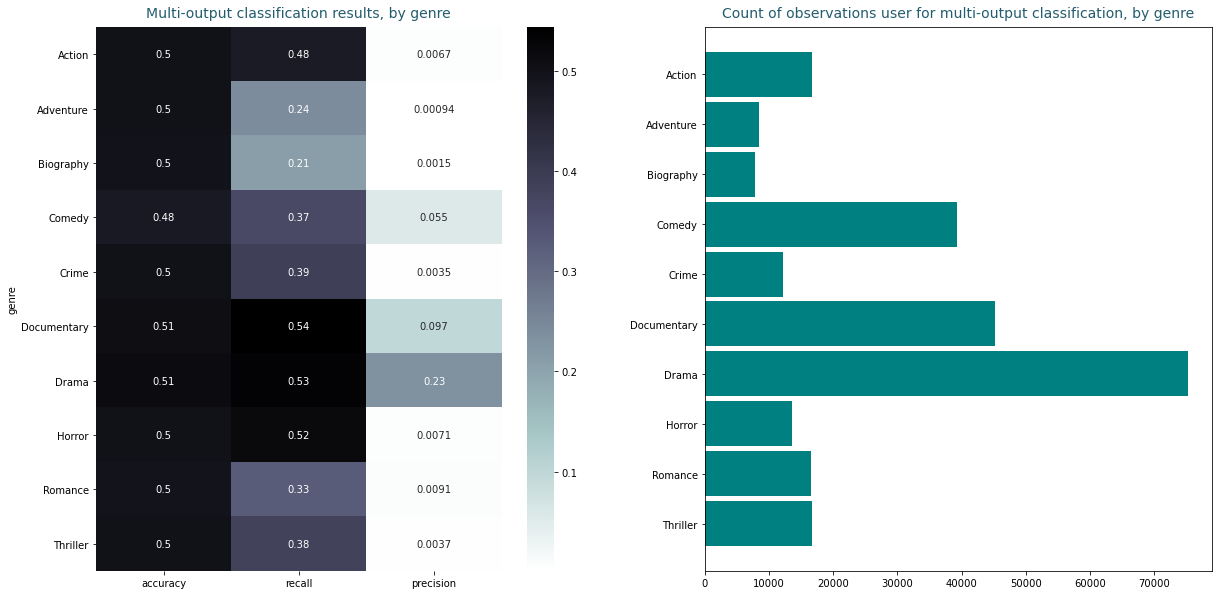

In [230]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title('Multi-output classification results, by genre', fontdict = {"color": '#245D6E', 'fontsize': 14, 'fontweight': 5}, pad = 10)
sns.heatmap(totals_comp[['accuracy', 'recall','precision']], cmap = 'bone_r', annot = True);
plt.subplot(1,2,2)
plt.title('Count of observations user for multi-output classification, by genre', fontdict = {"color": '#245D6E', 'fontsize': 14, 'fontweight': 5}, pad = 10)
plt.barh(genre_counts_df.iloc[:10,:].sort_values('genre', ascending = False)['genre'], genre_counts_df.iloc[:10,:].sort_values('genre', ascending = False)['count'], height = 0.9, color = 'teal')
plt.savefig('./post-dsi/NLP_movie-topics/moc_results.png', pad_inches = 0.2)

### 4. Conclusions

Clustering of movies into logical groupings based on their summaries was challenging 

The multi-output classifier trained on features extracted from movie summaries performed better for genres with more than 30,000 observations in the training dataset. Future exploration might include:<br>
- tuning the hyperparameters of the word vectorizer (e.g. to account for longer phrases like 4-grams or 5-grams, to find better thresholds for trimming the vocabulary, or to apply the term frequency-inverse document frequency logic),
- Training a neural network to more accurately perform the same multi-output classification task,
- Training a multi-output classifier with estimator objects other than KNC (e.g. Decision Tree),
- Using a combination of `summary` and `title` in predicting the genre,
- Training a binary classifier to only classify one genre at a time.